In [18]:
# --- Step 1: Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc
)

In [19]:
# --- Step 2: Load Dataset ---
df = pd.read_csv("C:/Users/DELL/Desktop/MSc/1st Sem/AML/Loan_Default - Copy.csv")

In [20]:
# --- Step 3: Data Exploration ---
print(df.head())
print(df.info())
print(df.describe())

      ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc                    b/c  ...   
2           p1                l1        nopc                  nob/c  ...   
3           p4                l1        nopc                  nob/c  ...   
4           p1                l1        nopc                  nob/c  ...   

   credit_type  Credit_Score  co-applicant_credit_type    age  \
0          EXP           758                 

In [21]:
# --- Show missing values as numbers ---
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing_values / len(df)) * 100
missing_table = pd.DataFrame({
    "Missing Values": missing_values,
    "Percentage": missing_percent
})
print("Missing Values Summary:")
print(missing_table[missing_table["Missing Values"] > 0])

Missing Values Summary:
                           Missing Values  Percentage
Upfront_charges                     13287   26.574531
Interest_rate_spread                12281   24.562491
rate_of_interest                    12209   24.418488
dtir1                                8072   16.144323
property_value                       5104   10.208204
LTV                                  5104   10.208204
income                               3008    6.016120
loan_limit                           1109    2.218044
approv_in_adv                         277    0.554011
age                                    72    0.144003
submission_of_application              72    0.144003
Neg_ammortization                      40    0.080002
loan_purpose                           38    0.076002
term                                   16    0.032001


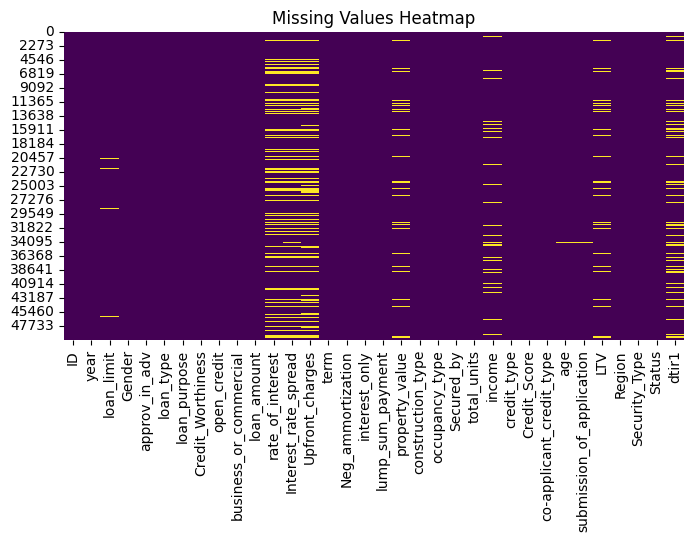

In [22]:
# Missing values
plt.figure(figsize=(8,4))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_11272\3176283813.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Status", data=df, palette="coolwarm")


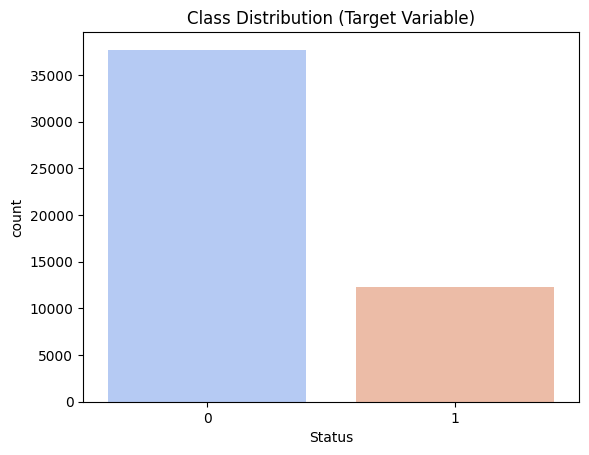

In [23]:
# Target distribution
sns.countplot(x="Status", data=df, palette="coolwarm")
plt.title("Class Distribution (Target Variable)")
plt.show()

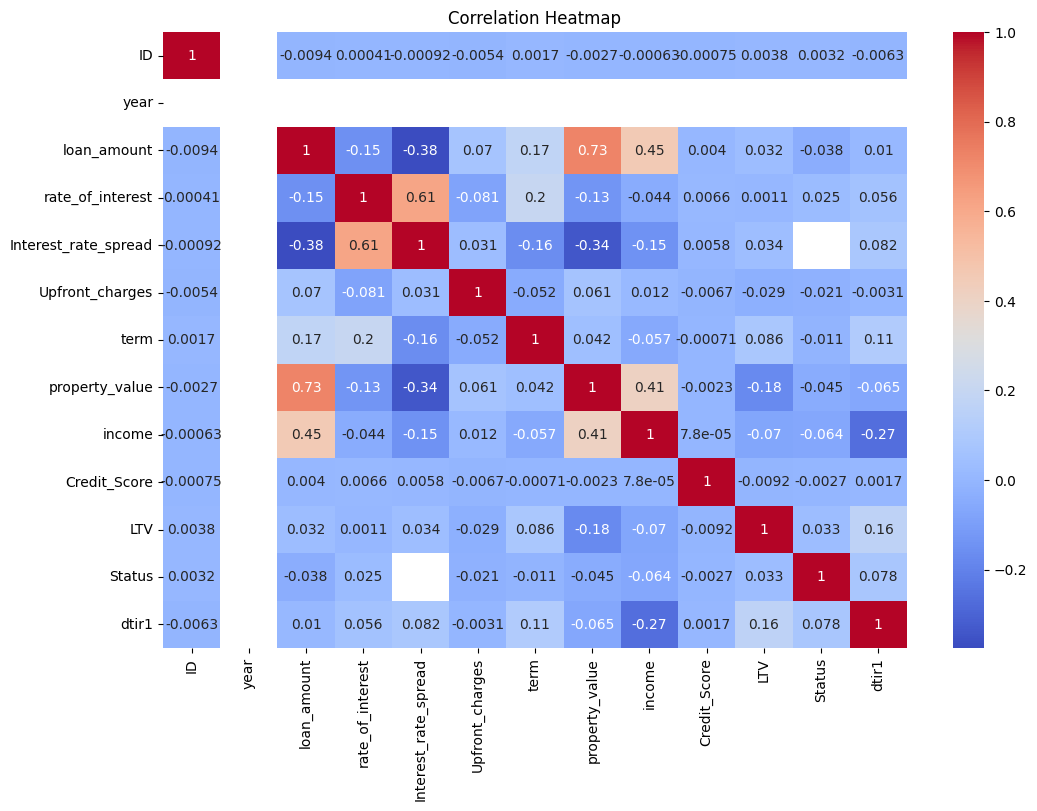

In [24]:
# Correlation heatmap (numerical features)
num_cols = df.select_dtypes(include=['int64','float64']).columns
plt.figure(figsize=(12,8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [25]:
# --- Step 4: Pre-Processing ---
# Separate numeric and categorical columns
num_cols = df.select_dtypes(include=['int64','float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

In [26]:
# Impute numeric
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Impute categorical
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# One-hot encode categorical features
encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
encoded_array = encoder.fit_transform(df[cat_cols])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_cols), index=df.index)

In [27]:
# Define X and y
X = pd.concat([df[num_cols].drop("Status", axis=1, errors="ignore"), encoded_df], axis=1)
y = df["Status"]

In [28]:
# --- Step 5: Split Data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

C:\Users\DELL\AppData\Local\Temp\ipykernel_11272\2497715867.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_res, palette="viridis")


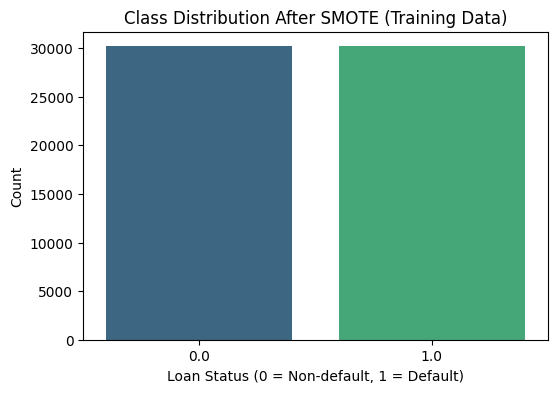

In [35]:
# Apply SMOTE on training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Class distribution after SMOTE
plt.figure(figsize=(6,4))
sns.countplot(x=y_train_res, palette="viridis")
plt.title("Class Distribution After SMOTE (Training Data)")
plt.xlabel("Loan Status (0 = Non-default, 1 = Default)")
plt.ylabel("Count")
plt.show()

In [30]:
# Scale features (NB requires scaling)
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [31]:
# --- Step 6a: Baseline Model ---
nb_model = GaussianNB()
nb_model.fit(X_train_res_scaled, y_train_res)

y_pred = nb_model.predict(X_test_scaled)

print("Baseline Naïve Bayes Results:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Baseline Naïve Bayes Results:
[[7544    0]
 [1290 1166]]
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92      7544
         1.0       1.00      0.47      0.64      2456

    accuracy                           0.87     10000
   macro avg       0.93      0.74      0.78     10000
weighted avg       0.89      0.87      0.85     10000



In [32]:
# --- Step 6b: Hyperparameter Tuning ---
param_grid = {"var_smoothing": np.logspace(-9, -2, 10)}
grid_nb = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring="f1", n_jobs=-1)
grid_nb.fit(X_train_res_scaled, y_train_res)

print("Best Parameters:", grid_nb.best_params_)

Best Parameters: {'var_smoothing': np.float64(0.01)}


In [33]:
# Final model
best_nb = grid_nb.best_estimator_
y_pred_best = best_nb.predict(X_test_scaled)

print("Tuned Naïve Bayes Results:")
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Tuned Naïve Bayes Results:
[[7528   16]
 [1148 1308]]
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      7544
         1.0       0.99      0.53      0.69      2456

    accuracy                           0.88     10000
   macro avg       0.93      0.77      0.81     10000
weighted avg       0.90      0.88      0.87     10000



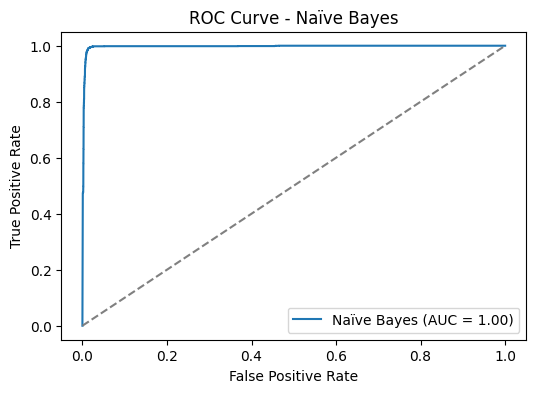

In [34]:
# --- Step 7: ROC Curve ---
y_proba = best_nb.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'Naïve Bayes (AUC = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naïve Bayes")
plt.legend()
plt.show()